<a href="https://colab.research.google.com/github/kd365/faafall22/blob/hunter_19mar/cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NTSB Cleaning Notebook

## Steps:
1. Import libraries and raw data
2. Initial column drops
3. Cleaning steps that wil apply to entire dataframe
4. Cleaning each column

**Cleaning Plan:**
Hunter:
- cols 0-22
Kathleen:
- col 23-45
Eric:
- col 46-68
Chi:
- col 69-85


### 1. Import libraries

In [5]:
from google.colab import files
import pandas as pd

uploaded = files.upload()

KeyboardInterrupt: ignored

In [158]:
import re
import numpy as np

In [108]:
# setting pandas display options
pd.set_option('display.max_rows', 150)

# reading in NTSB csv file
ntsb_raw = pd.read_csv("NTSB_for_cleaning.csv", encoding='latin-1', low_memory=False)
ntsb_raw = ntsb_raw.drop(['engines_ev_id', 'events_ev_id', 'Unnamed: 0'], axis=1)
# view the dataframe info
ntsb_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112803 entries, 0 to 112802
Data columns (total 86 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   aircraft_ev_id         112803 non-null  object 
 1   far_part               112080 non-null  object 
 2   flight_plan_activated  48716 non-null   object 
 3   damage                 111402 non-null  object 
 4   acft_make              112785 non-null  object 
 5   acft_model             112767 non-null  object 
 6   cert_max_gr_wt         98437 non-null   float64
 7   num_eng                110047 non-null  float64
 8   type_last_insp         104108 non-null  object 
 9   date_last_insp         87193 non-null   object 
 10  afm_hrs_last_insp      61174 non-null   float64
 11  afm_hrs                88035 non-null   float64
 12  type_fly               108038 non-null  object 
 13  dprt_apt_id            90502 non-null   object 
 14  dprt_city              94336 non-nul

### 2. Initial Drop

In [109]:
# need to delete duplicate records
ntsb_raw = ntsb_raw.drop_duplicates(subset='aircraft_ev_id', keep='last')
ntsb_raw.shape

(69635, 86)

In [110]:
# drop all records that do not have at least 50 columns worth of data in them
ntsb_raw = ntsb_raw.dropna(thresh=60)

In [111]:
# drop any columns that have more than 40% null values
total_rows = ntsb_raw.shape[0]

def drop_cols(df, df_size):
    # create a list of columns to drop
    drop = []
    # iterate over each column
    for x in df.columns:
        #determine if the ratio of nulls is greater than 30%
        ratio = (df[x].isna().sum()) / df_size
        if ratio > 0.5:
            drop.append(x)
    # drop the columns in the drop list
    df.drop(labels=drop, axis=1)
    print('Cols dropped from df:', drop)
    return df

ntsb_dropped_cols = drop_cols(ntsb_raw, total_rows)      


Cols dropped from df: ['flight_plan_activated', 'afm_hrs_since', 'eng_time_total', 'eng_time_last_insp', 'latitude', 'longitude', 'wx_dens_alt', 'Cause_Factor', 'crew_no', 'crew_category', 'crew_age', 'crew_sex', 'med_certf', 'crew_inj_level']


In [112]:
print(ntsb_dropped_cols.shape)

(57686, 86)


## 3. Cleaning that applies to entire data set

In [113]:
# function to initially clean up all strings in df
def df_string_transform(df):
    ''' 
    force all text data to lowercase and strip left and right side of strings
    in all string columns

    args: dataframe

    returns: dataframe
    '''
    df1 = df.applymap(lambda x: x.lower() if type(x) == str else x)
    df1 = df1.applymap(lambda x: x.strip() if type(x) == str else x)
    return df1

In [114]:
# applying the funcrition from above
ntsb_1 = df_string_transform(ntsb_dropped_cols)

In [115]:
print(ntsb_1.shape)

(57686, 86)


**NOTE**: for section 3 use the dataframe `ntsb_1` for cleaning

### 3. Cleaning Each Column

In [116]:
# function to show all the metrics you will want to see for each column
def col_metrics(df, col='none'):
  print('current df shape:', df.shape)
  print('Unique data: ', df[col].unique())
  print('Value counts: ', df[col].value_counts())
  print('Total nulls: ', df[col].isna().sum())
  print('Data type: ', df[col].dtypes)

### HUNTER'S SECTION

In [117]:
# column 1: far part
col_metrics(ntsb_1, col='far_part')      

# making a copy of the data set as ntsb_1
ntsb_1 = pd.DataFrame.copy(ntsb_1)

# remove the K and F from part 091
ntsb_1['far_part'] = ntsb_1['far_part'].str.replace('k', '').str.replace('f', '').str.replace('arm', '091')
print(ntsb_1['far_part'].unique())

current df shape: (57686, 86)
Unique data:  ['135' '091' '137' '103' 'armf' '091f' '091k' '437']
Value counts:  091     51939
135      2816
137      2790
103        90
091f       30
091k       11
armf        9
437         1
Name: far_part, dtype: int64
Total nulls:  0
Data type:  object
['135' '091' '137' '103' '437']


In [118]:
# column 2: 'flight_plan_activated'
col_metrics(ntsb_1, 'flight_plan_activated')

# dropping this column, too many nulls, and filing a flight plan is superfluous 
#because you can file in flight or you can use flight following
ntsb_1 = ntsb_1.drop(['flight_plan_activated'], axis=1)

current df shape: (57686, 86)
Unique data:  [nan 'y' 'n' 'u']
Value counts:  n    11604
y     3022
u      344
Name: flight_plan_activated, dtype: int64
Total nulls:  42716
Data type:  object


In [119]:
# column 3: 'damage'
col_metrics(ntsb_1, 'damage')

# change the unk to none
ntsb_1['damage'] = ntsb_1['damage'].str.replace('unk', 'none')
# drop the 491 rows that do not have a damage listing
ntsb_1 = ntsb_1.dropna(subset='damage')
print('final null count:', ntsb_1['damage'].isna().sum())

current df shape: (57686, 85)
Unique data:  ['subs' 'dest' 'none' 'minr' 'unk' nan]
Value counts:  subs    43662
dest    12728
minr      913
none      277
unk         9
Name: damage, dtype: int64
Total nulls:  97
Data type:  object
final null count: 0


In [120]:
# column 4: 'acft_make'
col_metrics(ntsb_1, 'acft_make')

# there are 6 rosw with nulls, will drop those
ntsb_1 = ntsb_1.dropna(subset=['acft_make'])
print(ntsb_1['acft_make'].isna().sum())

current df shape: (57589, 85)
Unique data:  ['cessna' 'piper' 'beech' ... 'gerald nelson' 'gonzalez manuel a'
 'harris-runyan']
Value counts:  cessna                      20123
piper                       10858
beech                        4099
bell                         1272
mooney                       1046
                            ...  
gary e. wilson                  1
lonnie w. ratliff               1
silvaggio                       1
s. piccolotto/dave morss        1
harris-runyan                   1
Name: acft_make, Length: 5333, dtype: int64
Total nulls:  8
Data type:  object
0


In [121]:
#if an aircraft make is not in the top 30, it will be categorized as other. 
acft_top_20 = ntsb_1['acft_make'].value_counts()[0:30].index.tolist()

ntsb_1['acft_make'] = ntsb_1['acft_make'].map(lambda x: 'other_make' if x not in acft_top_20 else x)

print(ntsb_1['acft_make'].value_counts())

cessna                            20123
other_make                        12062
piper                             10858
beech                              4099
bell                               1272
mooney                             1046
bellanca                            806
grumman                             799
robinson                            522
hughes                              487
aeronca                             451
schweizer                           429
maule                               414
champion                            369
luscombe                            317
stinson                             316
air tractor                         312
boeing                              304
aero commander                      290
taylorcraft                         282
north american                      276
rockwell                            228
de havilland                        201
enstrom                             198
hiller                              193


<ipython-input-121-c6079be1a600>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ntsb_1['acft_make'] = ntsb_1['acft_make'].map(lambda x: 'other_make' if x not in acft_top_20 else x)


In [122]:
# column 5: 'acft_model'
col_metrics(ntsb_1, 'acft_model')

# drop the 5 rows that have nulls
ntsb_1 = ntsb_1.dropna(subset=['acft_model'])

current df shape: (57581, 85)
Unique data:  ['207' 'pa-22-160' '300' ... 'rv 7' 'f4u 5' 'skybolt 300']
Value counts:  152                  1940
172                  1045
172n                  927
pa-28-140             779
172m                  646
                     ... 
tu-10                   1
as 355 f ecureuil       1
be35g                   1
twinstar ta-2           1
skybolt 300             1
Name: acft_model, Length: 7832, dtype: int64
Total nulls:  19
Data type:  object


In [123]:
# column 5

# remove the letters off the cessna model
pattern = r'\d\d\d\w'
ntsb_1['acft_model'] = ntsb_1['acft_model'].map(lambda x: re.sub(pattern, lambda match: match.group()[:-1], x))
print(ntsb_1['acft_model'].value_counts())

#if an aircraft make is not in the top 30, it will be categorized as other. 
model_top_30 = ntsb_1['acft_model'].value_counts()[0:30].index.tolist()

# change the model names to 'other_model' if not in the top 30
ntsb_1['acft_model'] = ntsb_1['acft_model'].map(lambda x: 'other_model' if x not in model_top_30 else x)

172                4555
150                2509
152                1956
182                1910
pa-28-140           796
                   ... 
b-100                 1
panther ii plus       1
musting ii            1
g-102 astir cs        1
skybolt 300           1
Name: acft_model, Length: 7235, dtype: int64


In [124]:
# column 6: 'cert_max_gr_wt'
col_metrics(ntsb_1, 'cert_max_gr_wt')
print(ntsb_1['cert_max_gr_wt'].max(), ntsb_1['cert_max_gr_wt'].min())

def weight_bins(df, col):
    avg_wt = df[col].mean()    
    wt_cat = []
    for x in list(df[col]):
        if x <= 12500:
            x = 'small'
            wt_cat.append(x)
        elif x > 12500 and x < 41000:
            x = 'medium'
            wt_cat.append(x)
        elif x == 'nan':
            if avg_wt <=12500:
                x = 'small'
                wt_cat.append(x)
            elif avg_wt > 12500 and x < 41000:
                x = 'medium'
                wt_cat.append(x)
            else:
                x = 'large commuter'
                wt_cat.append(x)
        else:
            x = 'large commuter'
            wt_cat.append(x)
    df[col] = wt_cat
    return df[col]

current df shape: (57562, 85)
Unique data:  [ 3800.  1840. 14100. ...  5333.  2497.  2251.]
Value counts:  1600.0      2600
2300.0      2597
1670.0      2224
3600.0      1533
2150.0      1530
            ... 
1297.0         1
22450.0        1
3609.0         1
358000.0       1
2251.0         1
Name: cert_max_gr_wt, Length: 2168, dtype: int64
Total nulls:  3060
Data type:  float64
870000.0 -3100.0


In [125]:
# use the bin function to assign categories to weight classes
ntsb_1['cert_max_gr_wt'] = weight_bins(ntsb_1, 'cert_max_gr_wt')

In [126]:
# column 7: 'num_eng'
col_metrics(ntsb_1, 'num_eng')

# convert the float to int and then impute the nulls with the median
ntsb_1['num_eng'] = ntsb_1['num_eng']

current df shape: (57562, 85)
Unique data:  [ 1.  2. nan  3.  4.  0.]
Value counts:  1.0    49699
2.0     6830
0.0      505
4.0       47
3.0       31
Name: num_eng, dtype: int64
Total nulls:  450
Data type:  float64


In [127]:
# change from float to int8
# fill na with 1
ntsb_1['num_eng'] = ntsb_1['num_eng'].fillna(1.0).astype('int8')


In [128]:
# column 8: 'type_last_insp'
col_metrics(ntsb_1, 'type_last_insp')

current df shape: (57562, 85)
Unique data:  ['100h' 'aaip' 'annl' 'unk' 'coaw' 'cond' nan]
Value counts:  annl    33108
unk      9332
100h     9106
cond     1716
aaip     1614
coaw     1478
Name: type_last_insp, dtype: int64
Total nulls:  1208
Data type:  object


In [129]:
# column 9: 'afm_hrs'
col_metrics(ntsb_1, 'afm_hrs')

current df shape: (57562, 85)
Unique data:  [10286.  14424.      nan ...  2341.8    53.2   967.5]
Value counts:  1.0        129
3000.0     105
2500.0      94
2000.0      90
4000.0      84
          ... 
8725.0       1
12005.0      1
6072.0       1
4976.0       1
967.5        1
Name: afm_hrs, Length: 13131, dtype: int64
Total nulls:  10560
Data type:  float64


In [130]:
ntsb_1['afm_hrs'].describe()

count     47002.000000
mean       3639.729272
std        4530.201239
min           0.000000
25%        1284.250000
50%        2711.900000
75%        4547.000000
max      233109.000000
Name: afm_hrs, dtype: float64

In [131]:
# count how many values are outliers
outlier = (1.5*(4752 - 1229)) + 4752
outliers = [x for x in ntsb_1['afm_hrs'] if x > outlier]
print(len(outliers))

2322


In [132]:
# fill na with median
#median = ntsb_1['afm_hrs'].median()
#ntsb_1['afm_hrs'] = ntsb_1['afm_hrs'].fillna(median)
# drop the outliers
ntsb_1 = ntsb_1[ntsb_1['afm_hrs'] < outlier]


<Axes: ylabel='Frequency'>

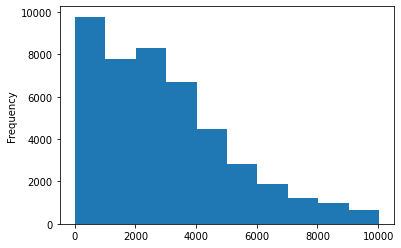

In [133]:
ntsb_1['afm_hrs'].plot.hist(bins=10)

In [134]:
ntsb_1.shape

(44680, 85)

In [135]:
# round and change to int32
ntsb_1['afm_hrs'] = ntsb_1['afm_hrs'].round().astype('int16')

In [136]:
# column 10: 'type_fly'
col_metrics(ntsb_1, 'type_fly')

current df shape: (44680, 85)
Unique data:  ['exec' 'pers' 'bus' 'inst' 'unk' 'pubu' 'posi' 'fery' 'owrk' 'aapl'
 'aobv' 'skyd' nan 'flts' 'asho' 'adrp' 'gldt' 'bant' 'publ' 'pubs' 'exld'
 'pubf' 'firf']
Value counts:  pers    28193
inst     6086
unk      2551
bus      2430
aapl     2066
posi      788
fery      449
owrk      434
exec      375
aobv      308
pubu      203
flts      201
skyd       71
asho       69
bant       46
gldt       19
pubs       12
publ        7
adrp        5
exld        5
pubf        5
firf        1
Name: type_fly, dtype: int64
Total nulls:  356
Data type:  object


In [137]:
# change the null to unknown
ntsb_1['type_fly'] = ntsb_1['type_fly'].fillna('unk')

In [138]:
# column 11: 'dprt_apt_id'
col_metrics(ntsb_1, 'dprt_apt_id')

current df shape: (44680, 85)
Unique data:  ['gmu' 'ox8' nan ... '37f' '62k' '38cl']
Value counts:  none    825
pvt     253
c       168
mri     164
apa     134
       ... 
ape       1
mkcr      1
neo8      1
0k9       1
38cl      1
Name: dprt_apt_id, Length: 7702, dtype: int64
Total nulls:  9657
Data type:  object


In [139]:
# column 12: 'dprt_city'
col_metrics(ntsb_1, 'dprt_city')

current df shape: (44680, 85)
Unique data:  ['greeneville' nan 'detroit city' ... 'kalaeloa' 'ishpeming' 'munday']
Value counts:  anchorage          330
las vegas          148
houston            145
columbus           138
fairbanks          129
                  ... 
kroto slough         1
big lake,ak          1
nunavarchak bch      1
denali airstrip      1
munday               1
Name: dprt_city, Length: 6753, dtype: int64
Total nulls:  9638
Data type:  object


In [140]:
# there are some city names that have commas and states after. remove those with commas
ntsb_1['dest_city'] = ntsb_1['dest_city'].str.split(',').str[0]


In [141]:
# column 13: 'dprt_state'
col_metrics(ntsb_1, 'dprt_state')

current df shape: (44680, 85)
Unique data:  ['sc' nan 'mi' 'mn' 'il' 'ks' 'mo' 'oh' 'ne' 'az' 'nm' 'tx' 'la' 'ok' 'in'
 'ca' 'me' 'or' 'ak' 'ga' 'co' 'nh' 'nv' 'fl' 'ma' 'de' 'pa' 'ct' 'ms'
 'al' 'nc' 'wy' 'tn' 'nj' 'hi' 'ky' 'vi' 'id' 'wa' 'ut' 'ar' 'va' 'pr'
 'ny' 'wv' 'mt' 'nd' 'vt' 'dc' 'ri' 'sd' 'ia' 'cd' 'md' 'wi' 'of' 'ah'
 'cn' 'bc' 'gm' 'mp' 'po' 'yt' 'mx' 'un' 'bh' 'ad' 'nb' 'pq' 'cb' 'gu'
 'ha' 'io' 'kn' 'ja' 'bi' 'ao' 'dr']
Value counts:  ca    3864
fl    2569
tx    2354
ak    1913
az    1247
co    1141
wa    1085
ga     974
mi     881
oh     873
ny     871
il     870
pa     851
nc     773
mo     708
wi     676
or     668
mn     637
va     612
in     577
id     576
nv     562
tn     559
nj     559
ut     557
nm     551
ar     545
al     529
ks     517
ok     513
sc     476
la     440
mt     408
ma     404
md     390
ia     366
ms     349
ne     326
ky     304
wy     299
me     258
ct     237
nd     235
sd     220
wv     187
nh     186
hi     174
vt     110
pr      89
ri    

In [142]:
# print out all the states that are incorrect
state_abbr = [
    "AL",  # Alabama
    "AK",  # Alaska
    "AZ",  # Arizona
    "AR",  # Arkansas
    "CA",  # California
    "CO",  # Colorado
    "CT",  # Connecticut
    "DE",  # Delaware
    "FL",  # Florida
    "GA",  # Georgia
    "HI",  # Hawaii
    "ID",  # Idaho
    "IL",  # Illinois
    "IN",  # Indiana
    "IA",  # Iowa
    "KS",  # Kansas
    "KY",  # Kentucky
    "LA",  # Louisiana
    "ME",  # Maine
    "MD",  # Maryland
    "MA",  # Massachusetts
    "MI",  # Michigan
    "MN",  # Minnesota
    "MS",  # Mississippi
    "MO",  # Missouri
    "MT",  # Montana
    "NE",  # Nebraska
    "NV",  # Nevada
    "NH",  # New Hampshire
    "NJ",  # New Jersey
    "NM",  # New Mexico
    "NY",  # New York
    "NC",  # North Carolina
    "ND",  # North Dakota
    "OH",  # Ohio
    "OK",  # Oklahoma
    "OR",  # Oregon
    "PA",  # Pennsylvania
    "RI",  # Rhode Island
    "SC",  # South Carolina
    "SD",  # South Dakota
    "TN",  # Tennessee
    "TX",  # Texas
    "UT",  # Utah
    "VT",  # Vermont
    "VA",  # Virginia
    "WA",  # Washington
    "WV",  # West Virginia
    "WI",  # Wisconsin
    "WY",  # Wyoming
    'gu', 
    'mp', 
    'pr',
    'tt',
    'vi'
]
print(len(state_abbr))
state_abbr = list(map(str.lower, state_abbr))

55


In [143]:
# incorrect states
wrong_states = set()
state_sum = []
for x in ntsb_1['dprt_state']:
  if (x not in state_abbr) and (x is not np.nan):
      wrong_states.add(x)
      state_sum.append(x)
print(len(state_sum))
print(wrong_states)

# drop the rows with incorrect state values
ntsb_1 = ntsb_1[~ntsb_1['dprt_state'].isin(wrong_states)]

210
{'of', 'ah', 'yt', 'un', 'cb', 'kn', 'ja', 'dr', 'bc', 'mx', 'io', 'gm', 'nb', 'dc', 'po', 'cd', 'pq', 'bh', 'ao', 'ha', 'bi', 'cn', 'ad'}


In [144]:
ntsb_1.shape

(44470, 85)

In [145]:
# column 14: 'dprt_time'
col_metrics(ntsb_1, 'dprt_time')

current df shape: (44470, 85)
Unique data:  [ 908. 1710. 1200. ...  156.   29.  322.]
Value counts:  0.0       3620
1400.0     856
1500.0     814
1600.0     737
1700.0     693
          ... 
626.0        1
103.0        1
195.0        1
193.0        1
322.0        1
Name: dprt_time, Length: 1354, dtype: int64
Total nulls:  1514
Data type:  float64


In [153]:
# change to string
ntsb_1['dprt_time'] = ntsb_1['dprt_time'].astype('str')

# remove all .o
ntsb_1['dprt_time'] = ntsb_1['dprt_time'].str.rstrip('.0')
times = []
for x in list(ntsb_1['dprt_time']):
    if len(x) == 1:
        x = '000' + x
        times.append(x)
    elif len(x) == 2:
        x = '00' + x
        times.append(x)
    elif len(x) == 3:
        x = '0' + x
        times.append(x)
    else:
        times.append(x)
ntsb_1['dprt_time'] = times
ntsb_1['dprt_time'].unique()


array(['0908', '0171', '0012', ..., '0156', '0029', '0322'], dtype=object)

In [157]:
import numpy as np
# column 14: 'dest_same_local'
col_metrics(ntsb_1, 'dest_same_local')

# three different versions of yes so standatdizing it
ntsb_1['dest_same_local'] = ntsb_1['dest_same_local'].str.replace('same', 'y').str.replace('locl', 'y').str.replace('spec', 'y')

def backfill_dprt_apt():
    dest = list(ntsb_1['dest_apt_id'])
    dept = list(ntsb_1[''])
    for x in ntsb_1['dest_apt_id']:
        if x == np.nan:
            x = 

current df shape: (44470, 85)
Unique data:  ['same' 'locl' nan 'spec' 'y']
Value counts:  locl    13672
same     9411
spec       18
y           1
Name: dest_same_local, dtype: int64
Total nulls:  21368
Data type:  object


In [155]:
# column 15: 'dest_apt_id'
col_metrics(ntsb_1, 'dest_apt_id')

current df shape: (44470, 85)
Unique data:  ['3a1' nan 'pln' ... 'vvs' '62k' '38cl']
Value counts:  none    537
c       206
pvt     194
apa     102
osh      84
       ... 
yyc       1
vyn       1
0l8       1
kso4      1
38cl      1
Name: dest_apt_id, Length: 6690, dtype: int64
Total nulls:  18261
Data type:  object


In [147]:
ntsb_1.columns

Index(['aircraft_ev_id', 'far_part', 'damage', 'acft_make', 'acft_model',
       'cert_max_gr_wt', 'num_eng', 'type_last_insp', 'date_last_insp',
       'afm_hrs_last_insp', 'afm_hrs', 'type_fly', 'dprt_apt_id', 'dprt_city',
       'dprt_state', 'dprt_time', 'dest_same_local', 'dest_apt_id',
       'dest_city', 'dest_state', 'phase_flt_spec', 'afm_hrs_since', 'rwy_num',
       'rwy_len', 'rwy_width', 'ifr_equipped_cert', 'eng_no', 'eng_type',
       'eng_mfgr', 'hp_or_lbs', 'carb_fuel_injection', 'eng_time_total',
       'eng_time_last_insp', 'ntsb_no', 'ev_type', 'ev_date', 'ev_dow',
       'ev_time', 'ev_city', 'ev_state', 'ev_year', 'ev_month', 'latitude',
       'longitude', 'apt_name', 'ev_nr_apt_id', 'ev_nr_apt_loc', 'apt_dist',
       'apt_dir', 'apt_elev', 'wx_src_iic', 'wx_obs_time', 'wx_obs_dir',
       'wx_obs_fac_id', 'wx_obs_elev', 'wx_obs_dist', 'light_cond',
       'sky_cond_nonceil', 'sky_nonceil_ht', 'sky_ceil_ht', 'sky_cond_ceil',
       'vis_rvr', 'vis_sm', 'wx_temp'